#### Dependencies

In [1]:
import sys
try:
    import docplex.cp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex
    else:
        !pip install 

In [2]:
try:
    import matplotlib
    if matplotlib.__version__ < "1.4.3":
        !pip install --upgrade matplotlib
except:
    !pip install matplotlib

In [3]:
from docplex.cp.model import CpoModel
from sys import stdout
from collections import namedtuple

#### Model the data

In [4]:
number_of_houses = 5
max_ammount_of_period = 318
HOUSES = range(1, number_of_houses + 1)
period_domain = (0, max_ammount_of_period)

In [5]:
Task = (namedtuple("Task", ["name", "duration"]))
TASKS = {Task("masonry", 35),
         Task("carpentry", 15),
         Task("plumbing",  40),
         Task("ceiling",   15),
         Task("roofing",    5),
         Task("painting",  10),
         Task("windows",    5),
         Task("facade",    10),
         Task("garden",     5),
         Task("moving",     5)
}

In [6]:
TaskPrecedence = (namedtuple("TaskPrecedence", ["beforeTask", "afterTask"]))
TASK_PRECEDENCES = {
    TaskPrecedence("masonry",   "carpentry"),
    TaskPrecedence("masonry",   "plumbing"),
    TaskPrecedence("masonry",   "ceiling"),
    TaskPrecedence("carpentry", "roofing"),
    TaskPrecedence("ceiling",   "painting"),
    TaskPrecedence("roofing",   "windows"),
    TaskPrecedence("roofing",   "facade"),
    TaskPrecedence("plumbing",  "facade"),
    TaskPrecedence("roofing",   "garden"),
    TaskPrecedence("plumbing",  "garden"),
    TaskPrecedence("windows",   "moving"),
    TaskPrecedence("facade",    "moving"),
    TaskPrecedence("garden",    "moving"),
    TaskPrecedence("painting",  "moving")
}

In [7]:
WORKERS = {"Joe", "Katie", "Sarah"}

In [8]:
Skill = (namedtuple("Skill", ["worker","task","level"]))
SKILLS = {
    Skill("Joe", "masonry", 9),
    Skill("Joe",  "carpentry", 7),
    Skill("Joe",  "ceiling",   5),
    Skill("Joe",  "roofing",   6),
    Skill("Joe",  "windows",   8),
    Skill("Joe",  "facade",    5),
    Skill("Joe",  "garden",    5),
    Skill("Joe",  "moving",    6),
    Skill("Katie", "masonry",   5),
    Skill("Katie", "plumbing",  7),
    Skill("Katie", "ceiling",   8),
    Skill("Katie", "roofing",   7),
    Skill("Katie", "painting",  9),
    Skill("Katie", "facade",    5),
    Skill("Katie", "garden",    5),
    Skill("Sarah",  "carpentry", 5),
    Skill("Sarah",  "painting",  6),
    Skill("Sarah",  "windows",   5),
    Skill("Sarah",  "garden",    9),
    Skill("Sarah",  "moving",    8)
}

In [9]:
def find_tasks(name):
    return next(t for t in TASKS if t.name == name)

def find_skill(worker, task):
    return next(s for s in SKILLS if (s.worker == worker) and (s.task == task))
def find_max_level_skill(task):
    st = [s for s in SKILLS if s.task == task]
    return next(sk for sk in st if sk.level == max([s.level for s in st]))

In [10]:
print(find_tasks("masonry"))
print(find_skill("Sarah","moving"))
print(find_max_level_skill("carpentry"))

Task(name='masonry', duration=35)
Skill(worker='Sarah', task='moving', level=8)
Skill(worker='Joe', task='carpentry', level=7)


#### Set up the prescriptive model

In [11]:
mdl = CpoModel(name="HouseBuilding")
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.00 sec
 - number of integer variables:  0
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        0
 - number of root expressions:   0
 - number of expression nodes:   0
 - operations:                   None


#### Define the decision variables

##### 1. Interval variable

In [12]:
tasks = {} # dict of interval variable for each house and task
for house in HOUSES:
    for task in TASKS:
        tasks[(house, task)] = mdl.interval_var(start=period_domain,
                                                end=period_domain,
                                                size=task.duration,
                                                name="house {} task {}".format(house, task))
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.00 sec
 - number of integer variables:  0
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        0
 - number of root expressions:   0
 - number of expression nodes:   0
 - operations:                   None


##### 2. Optional Interval Variable

In [14]:
wtasks = {} # dict of interval variable for each house and skill
for house in HOUSES:
    for skill in SKILLS:
        wtasks[(house, skill)] = mdl.interval_var(optional=True, name = 'H' + str(house) + '_' + skill.task + '(' + skill.worker + ')')
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.00 sec
 - number of integer variables:  0
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        0
 - number of root expressions:   0
 - number of expression nodes:   0
 - operations:                   None


##### 3. Precedence constraint

In [16]:
for h in HOUSES:
    for p in TASK_PRECEDENCES:
        mdl.add(mdl.end_before_start(tasks[(h, find_tasks(p.beforeTask))],tasks[(h, find_tasks(p.afterTask))]))
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.07 sec
 - number of integer variables:  0
 - number of interval variables: 50
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        70
 - number of root expressions:   70
 - number of expression nodes:   120
 - operations:                   endBeforeStart: 70


##### 4. Alternative Constraint

In [17]:
for h in HOUSES:
    for t in TASKS:
        mdl.add(mdl.alternative(tasks[(h, t)], [wtasks[(h,s)] for s in SKILLS if (s.task == t.name)],1))
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.08 sec
 - number of integer variables:  0
 - number of interval variables: 150
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        120
 - number of root expressions:   120
 - number of expression nodes:   370
 - operations:                   alternative: 50, endBeforeStart: 70


##### 5. No overlap constraint

In [18]:
for w in WORKERS:
    mdl.add(mdl.no_overlap([wtasks[(h, s)] for h in HOUSES for s in SKILLS if s.worker == w]))
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.09 sec
 - number of integer variables:  0
 - number of interval variables: 150
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        123
 - number of root expressions:   123
 - number of expression nodes:   376
 - operations:                   alternative: 50, endBeforeStart: 70, noOverlap: 3


#### Solve the Model

In [19]:
obj = mdl.sum([s.level * mdl.presence_of(wtasks[(h, s)]) for s in SKILLS for h in HOUSES])
mdl.add(mdl.maximize(obj))
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.11 sec
 - number of integer variables:  0
 - number of interval variables: 150
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        124
 - number of root expressions:   124
 - number of expression nodes:   679
 - operations:                   alternative: 50, endBeforeStart: 70, maximize: 1, noOverlap: 3, presenceOf: 100, sum: 1, times: 100


In [20]:
mdl.print_information()

Model: HouseBuilding
 - source file: /tmp/ipykernel_6409/618649854.py
 - modeling time: 0.11 sec
 - number of integer variables:  0
 - number of interval variables: 150
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        124
 - number of root expressions:   124
 - number of expression nodes:   679
 - operations:                   alternative: 50, endBeforeStart: 70, maximize: 1, noOverlap: 3, presenceOf: 100, sum: 1, times: 100


In [21]:
# Solve the model
print("\nSolving model....")
msol = mdl.solve(TimeLimit=10)


Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Maximization problem - 153 variables, 123 constraints
 ! TimeLimit            = 10
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 330.1 (before), 330.1 (after)
 !  . Memory usage      : 926.2 kB (before), 926.2 kB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        153                 -
 + New bound is 385
 ! Using iterative diving.
 ! Using temporal relaxation.
                        0        153    1            -
 + New bound is 372
 *           323      118  0.17s        1      (gap is 15.17%)
 *           324      339  0.17s        1      (gap is 14.81%)
 *           326      449  0.17s        1      (gap is 14.11%)
 *           329      559  0.17s        1   

#### Solution

In [22]:
print("Solve status: " + msol.get_solve_status())
if msol.is_solution():
    stdout.write("Solve time: " + str(msol.get_solve_time()) + "\n")
    # Sort tasks in increasing begin order
    ltasks = []
    for hs in HOUSES:
        for tsk in TASKS:
            (beg, end, dur) = msol[tasks[(hs, tsk)]]
            ltasks.append((hs, tsk, beg, end, dur))
    ltasks = sorted(ltasks, key = lambda x : x[2])
    # Print solution
    print("\nList of tasks in increasing start order:")
    for tsk in ltasks:
        print("From " + str(tsk[2]) + " to " + str(tsk[3]) + ", " + tsk[1].name + " in house " + str(tsk[0]))
else:
    stdout.write("No solution found\n")


Solve status: Feasible
Solve time: 10.01

List of tasks in increasing start order:
From 0 to 35, masonry in house 1
From 0 to 35, masonry in house 2
From 35 to 50, ceiling in house 2
From 35 to 70, masonry in house 4
From 50 to 65, ceiling in house 1
From 50 to 60, painting in house 2
From 65 to 75, painting in house 1
From 65 to 105, plumbing in house 2
From 70 to 105, masonry in house 5
From 75 to 90, carpentry in house 4
From 105 to 140, masonry in house 3
From 105 to 120, ceiling in house 4
From 120 to 160, plumbing in house 1
From 140 to 155, carpentry in house 3
From 155 to 170, ceiling in house 3
From 160 to 200, plumbing in house 3
From 170 to 185, carpentry in house 1
From 170 to 180, painting in house 3
From 185 to 200, carpentry in house 5
From 200 to 240, plumbing in house 5
From 200 to 215, ceiling in house 5
From 215 to 230, carpentry in house 2
From 215 to 225, painting in house 5
From 230 to 235, roofing in house 2
From 235 to 240, garden in house 2
From 235 to 240, win

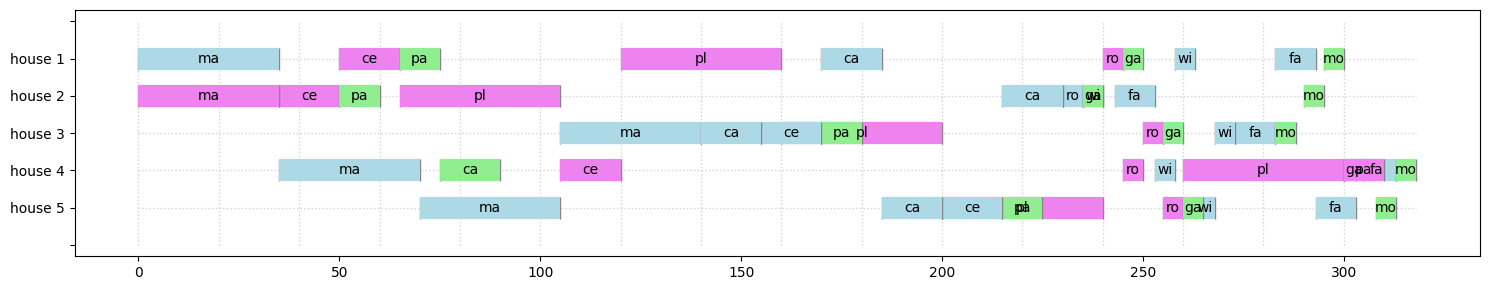

In [25]:
POP_UP_GRAPHIC=False

import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
if not POP_UP_GRAPHIC:
    %matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

def compact_name(name,n): return name[:n]

if msol and visu.is_visu_enabled():
    workers_colors = {}
    workers_colors["Joe"] = 'lightblue'
    workers_colors["Katie"] = 'violet'
    workers_colors["Sarah"] = 'lightgreen'
    visu.timeline('Solution per houses', 0, max_ammount_of_period)
    for h in HOUSES:
        visu.sequence(name="house " + str(h))
        for s in SKILLS:
            wt = msol.get_var_solution(wtasks[(h,s)])
            if wt.is_present():
                color = workers_colors[s.worker]
                wtname = compact_name(s.task,2)
                visu.interval(wt, color, wtname)
    visu.show()